In [37]:
!pip install dpkt

In [38]:
!pip install scapy

In [39]:
file_path = "drive/MyDrive/BOTNET DATASET/1_botnet-capture-20110810-neris.pcap"

In [40]:
from scapy.all import rdpcap

packets = rdpcap(file_path)

In [41]:
ip_packet_counts = {}

for packet in packets:

    if 'IP' in packet:
        src_ip = packet['IP'].src
        dst_ip = packet['IP'].dst

        ip_packet_counts[src_ip] = ip_packet_counts.get(src_ip, {'source_packets': 0, 'destination_packets': 0})
        ip_packet_counts[src_ip]['source_packets'] += 1

        ip_packet_counts[dst_ip] = ip_packet_counts.get(dst_ip, {'source_packets': 0, 'destination_packets': 0})
        ip_packet_counts[dst_ip]['destination_packets'] += 1

for ip, counts in ip_packet_counts.items():
    print("Source IP:", ip)
    print("Number of Source Packets:", counts['source_packets'])
    print("Number of Destination Packets:", counts['destination_packets'])
    print()

Streaming output truncated to the last 5000 lines.
Source IP: 217.65.6.11
Number of Source Packets: 1
Number of Destination Packets: 2

Source IP: 188.40.156.112
Number of Source Packets: 2
Number of Destination Packets: 4

Source IP: 209.51.200.34
Number of Source Packets: 1
Number of Destination Packets: 2

Source IP: 212.91.195.131
Number of Source Packets: 1
Number of Destination Packets: 2

Source IP: 213.239.204.146
Number of Source Packets: 1
Number of Destination Packets: 2

Source IP: 92.240.70.1
Number of Source Packets: 1
Number of Destination Packets: 2

Source IP: 213.189.224.33
Number of Source Packets: 1
Number of Destination Packets: 2

Source IP: 91.209.127.37
Number of Source Packets: 2
Number of Destination Packets: 4

Source IP: 128.32.136.3
Number of Source Packets: 1
Number of Destination Packets: 2

Source IP: 62.103.149.57
Number of Source Packets: 1
Number of Destination Packets: 2

Source IP: 92.241.70.35
Number of Source Packets: 0
Number of Destination Packe

In [42]:
from scapy.all import rdpcap,IP
from scapy.all import *
from collections import defaultdict
import os

os.makedirs("assets", exist_ok=True)

def flow_ingestion(flow_data):
    aggregated_flows = defaultdict(lambda: {'srcpkts': 0, 'dstpkts': 0})

    for flow in flow_data:
        sip, dip, srcpkts, dstpkts = flow
        key = (sip, dip)
        reverse = (dip, sip)
        if key in aggregated_flows:
            aggregated_flows[key]['srcpkts'] += srcpkts
            aggregated_flows[key]['dstpkts'] += dstpkts
        elif reverse in aggregated_flows:
            aggregated_flows[reverse]['srcpkts'] += dstpkts
            aggregated_flows[reverse]['dstpkts'] += srcpkts
        else:
            aggregated_flows[key] = {'srcpkts': srcpkts, 'dstpkts': dstpkts}
    return [(sip, dip, data['srcpkts'], data['dstpkts']) for (sip, dip), data in aggregated_flows.items()]

def extract_flow_data(packets):
    flow_data = []
    for pkt in packets:
        if IP in pkt:
            sip = pkt[IP].src
            dip = pkt[IP].dst
            srcpkts = 1
            dstpkts = 0
            flow_data.append((sip, dip, srcpkts, dstpkts))
    return flow_data

flow_data = extract_flow_data(packets)

aggregated_flows = flow_ingestion(flow_data)


print(aggregated_flows)



[('147.32.84.165', '147.32.84.255', 394, 0), ('147.32.84.165', '147.32.80.9', 14870, 7421), ('147.32.84.165', '74.125.232.195', 22, 7), ('147.32.84.165', '224.0.0.22', 4, 0), ('147.32.84.165', '239.255.255.250', 6, 0), ('147.32.84.165', '60.190.222.139', 94, 85), ('147.32.84.165', '94.63.149.152', 114, 40), ('147.32.84.165', '60.190.223.75', 298, 132), ('147.32.84.165', '195.88.191.59', 728, 440), ('147.32.84.165', '122.224.6.164', 236, 113), ('147.32.84.171', '147.32.84.165', 79, 132), ('147.32.84.165', '174.133.57.141', 4292, 1653), ('147.32.84.165', '61.147.99.179', 84, 40), ('147.32.84.165', '94.63.150.20', 116, 56), ('147.32.84.165', '74.222.3.26', 126, 63), ('147.32.84.165', '222.88.205.195', 1004, 425), ('147.32.84.165', '62.209.146.67', 20, 3), ('147.32.84.165', '94.95.56.138', 18, 5), ('147.32.84.165', '86.126.40.27', 6, 0), ('147.32.84.165', '77.127.110.198', 20, 3), ('147.32.84.165', '117.205.50.80', 10, 0), ('147.32.84.165', '188.129.211.240', 26, 0), ('147.32.84.165', '49.

In [43]:
from scapy.all import rdpcap, IP
from collections import defaultdict
import pandas as pd
import os

os.makedirs("assets", exist_ok=True)

def flow_ingestion(flow_data):
    aggregated_flows = defaultdict(lambda: {'srcpkts': 0, 'dstpkts': 0})

    for flow in flow_data:
        sip, dip, srcpkts, dstpkts = flow
        key = (sip, dip)
        reverse = (dip, sip)
        if key in aggregated_flows:
            aggregated_flows[key]['srcpkts'] += srcpkts
            aggregated_flows[key]['dstpkts'] += dstpkts
        elif reverse in aggregated_flows:
            aggregated_flows[reverse]['srcpkts'] += dstpkts
            aggregated_flows[reverse]['dstpkts'] += srcpkts
        else:
            aggregated_flows[key] = {'srcpkts': srcpkts, 'dstpkts': dstpkts}

    df = pd.DataFrame(columns=['source_ip', 'destination_ip', 'source_packets', 'dest_packets'])
    for (sip, dip), data in aggregated_flows.items():
        df = pd.concat([df, pd.DataFrame({'source_ip': [sip], 'destination_ip': [dip],
                                           'source_packets': [data['srcpkts']], 'dest_packets': [data['dstpkts']]})], ignore_index=True)

    return df

def extract_flow_data(packets):
    flow_data = []
    for pkt in packets:
        if IP in pkt:
            sip = pkt[IP].src
            dip = pkt[IP].dst
            srcpkts = 1
            dstpkts = 0
            flow_data.append((sip, dip, srcpkts, dstpkts))
    return flow_data

# Assuming you have 'packets' defined elsewhere in your code
flow_data = extract_flow_data(packets)

aggregated_flows_df = flow_ingestion(flow_data)

# Save DataFrame to CSV
aggregated_flows_df.to_csv('initial_preprocessing.csv', index=False)

print("CSV file saved successfully.")


CSV file saved successfully.


## Performing Exploratory Data Analysis

In [44]:
import pandas as pd

df = pd.read_csv('initial_preprocessing.csv')


In [45]:
print(df.head())
print(df.dtypes)
print(df.describe())
print(df.isnull().sum())

       source_ip   destination_ip  source_packets  dest_packets
0  147.32.84.165    147.32.84.255             394             0
1  147.32.84.165      147.32.80.9           14870          7421
2  147.32.84.165   74.125.232.195              22             7
3  147.32.84.165       224.0.0.22               4             0
4  147.32.84.165  239.255.255.250               6             0
source_ip         object
destination_ip    object
source_packets     int64
dest_packets       int64
dtype: object
       source_packets  dest_packets
count     4240.000000   4240.000000
mean        56.238443     19.763443
std        824.737695    401.139784
min          1.000000      0.000000
25%          2.000000      0.000000
50%          6.000000      1.000000
75%         12.000000      2.000000
max      35018.000000  17566.000000
source_ip         0
destination_ip    0
source_packets    0
dest_packets      0
dtype: int64


In [46]:
categorical = df.select_dtypes(include="object").columns

print(categorical)

numerical = df.select_dtypes(exclude="object").columns

print(numerical)

Index(['source_ip', 'destination_ip'], dtype='object')
Index(['source_packets', 'dest_packets'], dtype='object')


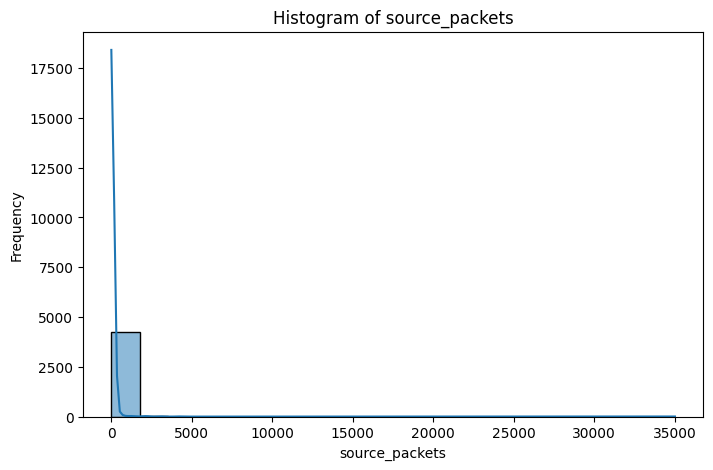

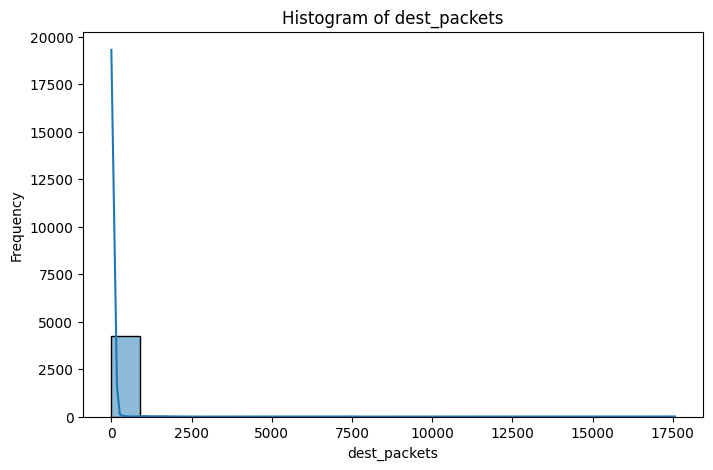

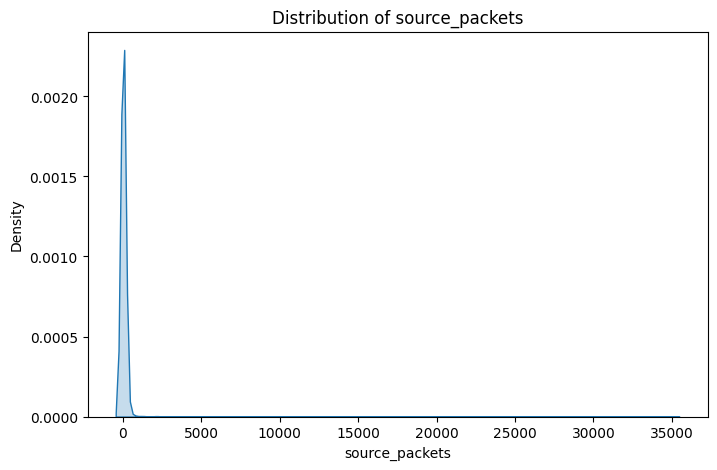

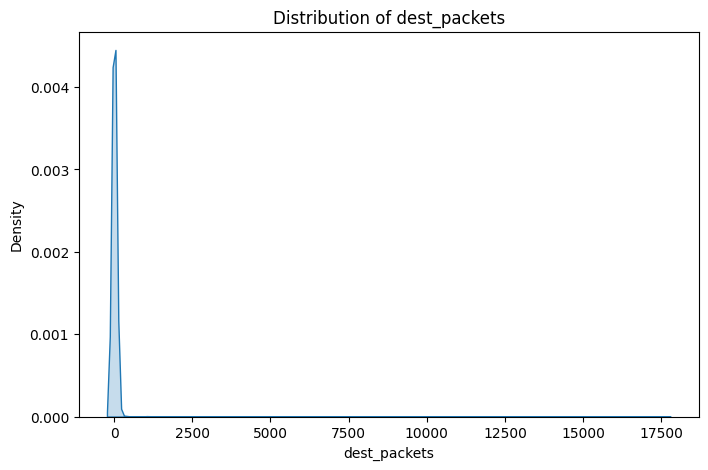

<Figure size 1200x800 with 0 Axes>

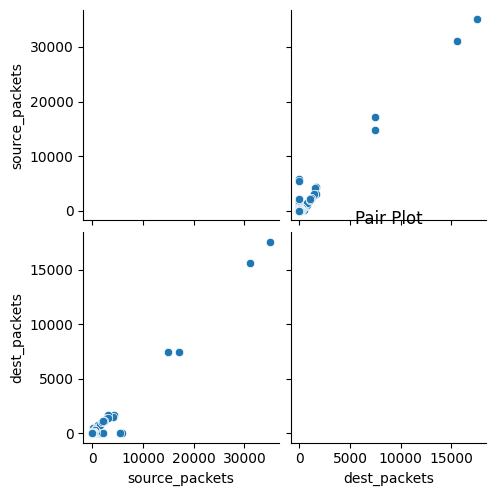

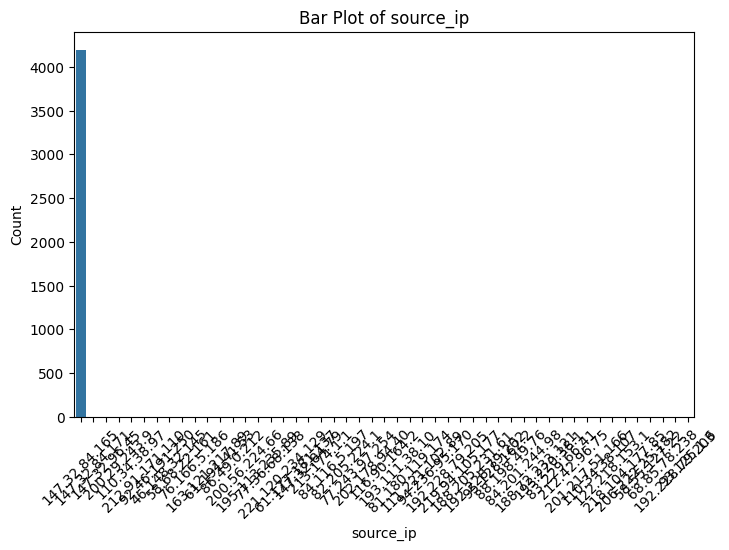

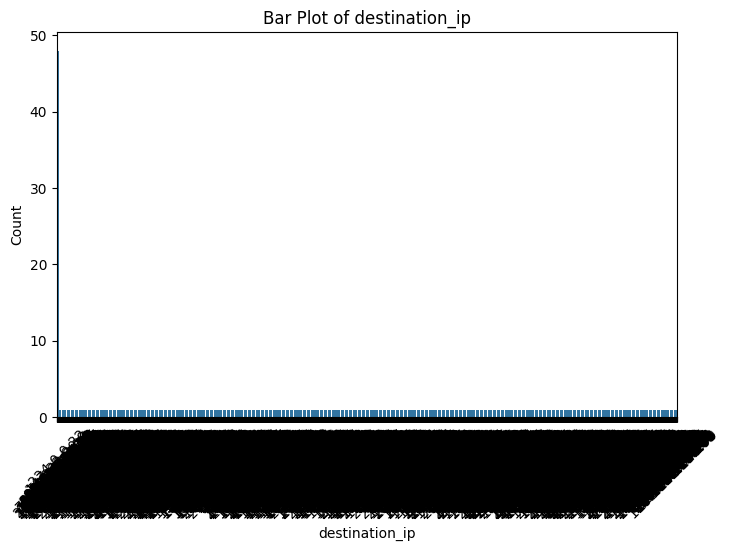

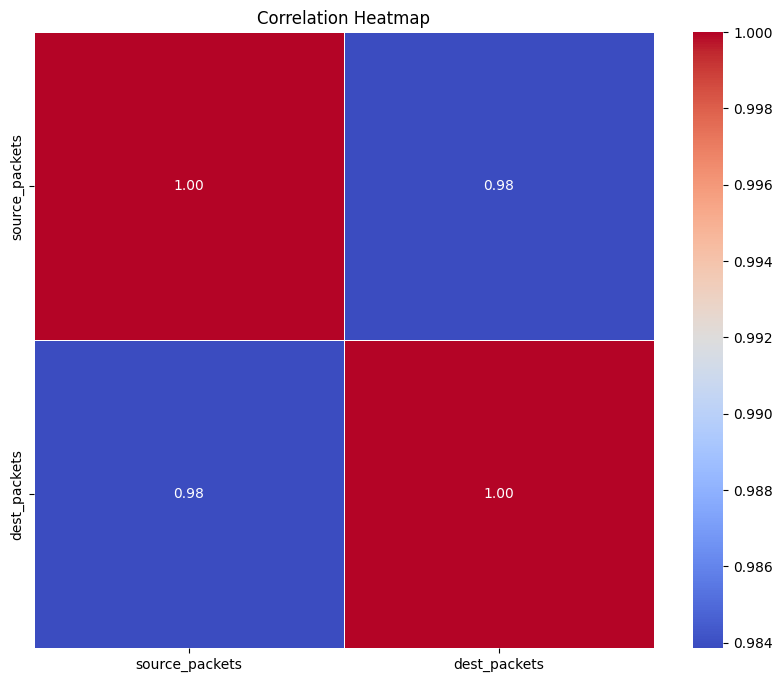

Skewness in Distribution:
source_packets    34.291837
dest_packets      36.627141
dtype: float64
Outliers:
{'source_packets': Int64Index([   0,    1,    5,    6,    7,    8,    9,   10,   11,   12,
            ...
            3915, 3994, 3999, 4018, 4023, 4086, 4117, 4120, 4122, 4152],
           dtype='int64', length=597), 'dest_packets': Int64Index([   1,    2,    5,    6,    7,    8,    9,   10,   11,   12,
            ...
            3824, 3894, 4012, 4081, 4092, 4120, 4122, 4123, 4152, 4160],
           dtype='int64', length=502)}


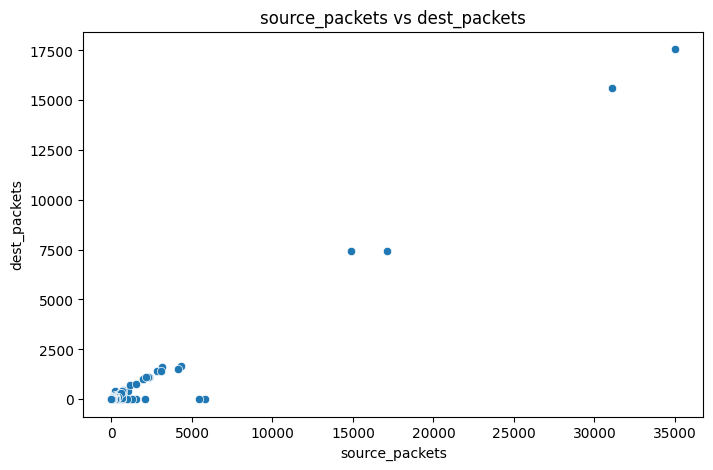

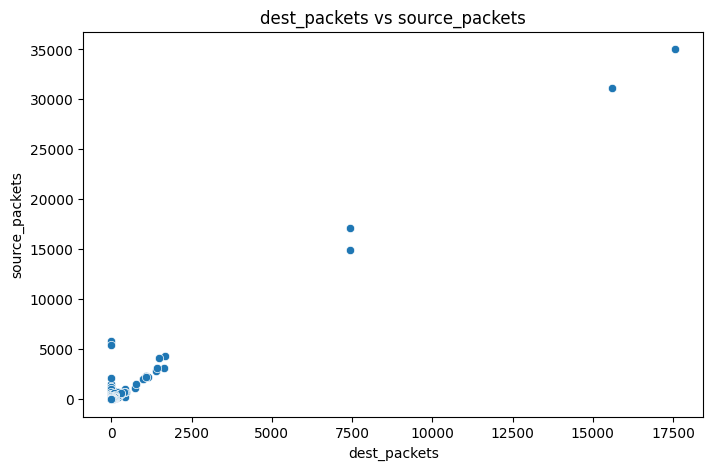

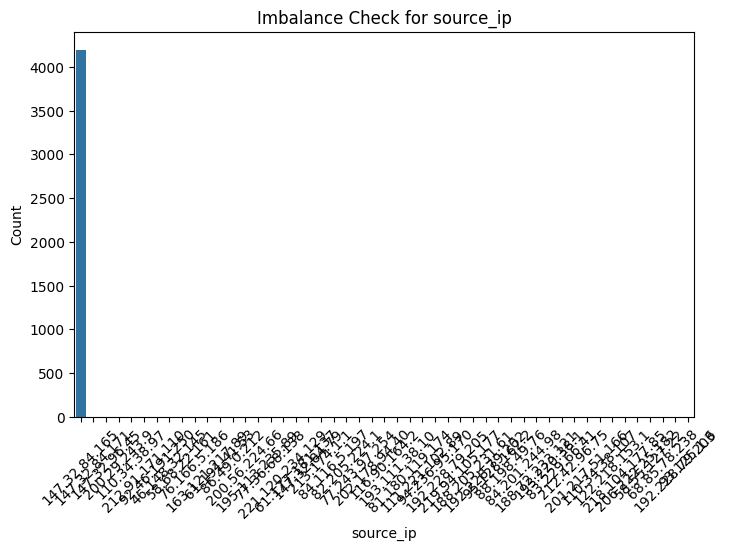

147.32.84.165      4192
193.111.38.10         1
111.221.102.89        1
94.236.95.170         1
192.228.79.205        1
219.94.105.177        1
188.205.231.61        1
192.228.79.202        1
95.128.162.2          1
88.198.49.76          1
84.201.244.98         1
188.72.233.121        1
193.220.38.1          1
83.229.66.41          1
212.42.96.75          1
201.217.51.166        1
110.34.38.107         1
122.218.153.1         1
218.104.177.85        1
206.222.25.182        1
58.55.127.22          1
68.85.78.238          1
192.228.79.203        1
81.180.119.174        1
116.90.164.2          1
147.32.84.171         1
202.178.94.40         1
147.32.96.45          1
200.29.243.9          1
110.34.38.97          1
212.91.171.110        1
92.46.191.250         1
46.148.32.145         1
58.68.22.161          1
76.166.5.186          1
163.121.217.89        1
61.191.41.53          1
86.49.0.212           1
200.56.224.66         1
195.113.235.89        1
77.36.68.138          1
221.120.234.129 

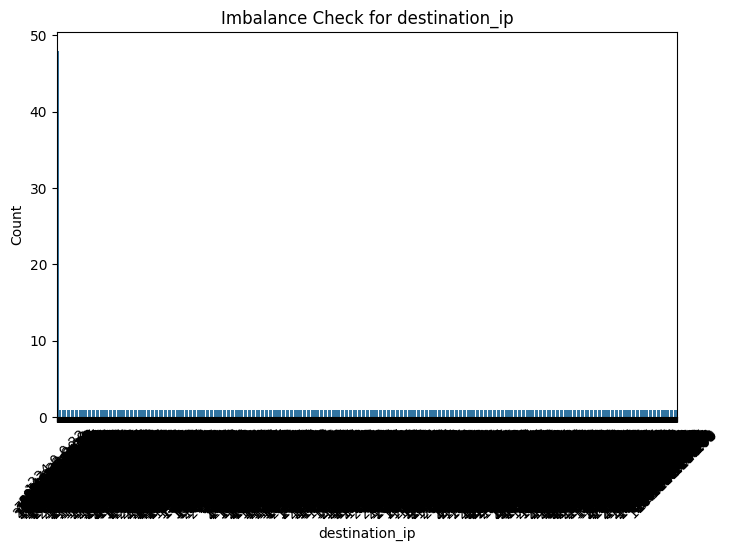

147.32.84.165     48
147.32.84.255      1
213.154.241.28     1
213.170.64.33      1
212.0.67.58        1
                  ..
195.24.65.155      1
62.149.205.244     1
193.252.22.185     1
98.139.212.139     1
202.59.166.29      1
Name: destination_ip, Length: 4193, dtype: int64


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms
def plot_histograms(df, numerical):
    for col in numerical:
        plt.figure(figsize=(8, 5))
        sns.histplot(data=df, x=col, bins=20, kde=True)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

plot_histograms(df, numerical)

# Distribution
def plot_distribution(df, numerical):
    for col in numerical:
        plt.figure(figsize=(8, 5))
        sns.kdeplot(data=df, x=col, fill=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.show()

plot_distribution(df, numerical)

# Pair Plot
def plot_pair_plot(df, numerical):
    plt.figure(figsize=(12, 8))
    sns.pairplot(df[numerical])
    plt.title('Pair Plot')
    plt.show()

plot_pair_plot(df, numerical)

# Bar Plot
def plot_bar_plot(df, categorical):
    for col in categorical:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=col)
        plt.title(f'Bar Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

plot_bar_plot(df, categorical)

# Correlation Heatmap
def plot_corr_heatmap(df, numerical):
    plt.figure(figsize=(10, 8))
    corr = df[numerical].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

plot_corr_heatmap(df, numerical)

# Skewness in Distribution
skewness = df[numerical].skew()
print("Skewness in Distribution:")
print(skewness)

# Outliers detection
def detect_outliers(df, numerical):
    outliers = {}
    for col in numerical:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outliers[col] = outlier_indices
    return outliers

outliers = detect_outliers(df, numerical)
print("Outliers:")
print(outliers)

# Relation between features (scatter plots)
def plot_scatter_plots(df, numerical):
    for col1 in numerical:
        for col2 in numerical:
            if col1 != col2:
                plt.figure(figsize=(8, 5))
                sns.scatterplot(data=df, x=col1, y=col2)
                plt.title(f'{col1} vs {col2}')
                plt.xlabel(col1)
                plt.ylabel(col2)
                plt.show()

plot_scatter_plots(df, numerical)

# Imbalance check (for categorical features)
def check_imbalance(df, categorical):
    for col in categorical:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=col)
        plt.title(f'Imbalance Check for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        print(df[col].value_counts())

check_imbalance(df, categorical)
